In [1]:
import os
import json
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import statistics

from scipy.stats import ttest_ind, shapiro, mannwhitneyu


In [2]:

path = r'corpus_finished'

# Load German tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('de_core_news_md')

# Function to extract nouns from a text
def extract_nouns(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == 'NOUN']

# Initialize data structures
nouns_gender = {'m': Counter(), 'w': Counter()}
noun_ratios_gender = {'m': [], 'w': []}

# Iterate over .json files
for filename in os.listdir(path):
    if filename.endswith('.json'):
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as f:
            data = json.load(f)
            gender = data['gender']
            poem_text = ' '.join(line['text'] for line in data['poem'].values())
            nouns = extract_nouns(poem_text)
            ratio = len(nouns) / len(poem_text.split())
            nouns_gender[gender].update(nouns)
            noun_ratios_gender[gender].append(ratio)

# Calculate average noun ratios for each gender and category
average_ratios_gender = {gender: sum(ratios) / len(ratios) for gender, ratios in noun_ratios_gender.items()}

all_genders = sorted(list(average_ratios_gender.keys()))

# Create a bar chart for each category, comparing genders
#bar_width = 0.35
#index = np.arange(len(selected_categories))

#plt.figure(figsize=(5, 5))

#for i, gender in enumerate(all_genders):
#    ratios = [average_ratios_gender_category[gender].get(category, 0) for category in selected_categories]
#    plt.bar(index + i * bar_width, ratios, bar_width, label=gender)

#plt.title('Average Relative Noun Ratio by Selected Categories and Gender')
#plt.xlabel('Category')
#plt.ylabel('Average Relative Noun Ratio')
#plt.xticks(index + bar_width / 2, selected_categories, rotation=90)
#plt.legend()
#plt.tight_layout()
#plt.show()

# Print the overall, median, minimum and maximum noun ratio for each gender
for gender in all_genders:
    all_ratios = noun_ratios_gender[gender]
    print(f'Gender: {gender}')
    print('Overall average relative noun ratio:', sum(all_ratios) / len(all_ratios))
    print('Median relative noun ratio:', statistics.median(all_ratios))
    print('Minimum relative noun ratio:', min(all_ratios))
    print('Maximum relative noun ratio:', max(all_ratios), '\n')

# Print the 10 most common nouns for each gender and selected category
for gender in all_genders:
    print(f'Gender: {gender}')
    print('10 most common nouns', nouns_gender[gender].most_common(10))


Gender: m
Overall average relative noun ratio: 0.22953057654049852
Median relative noun ratio: 0.2222222222222222
Minimum relative noun ratio: 0.0136986301369863
Maximum relative noun ratio: 0.38636363636363635 

Gender: w
Overall average relative noun ratio: 0.21992613278808584
Median relative noun ratio: 0.21978021978021978
Minimum relative noun ratio: 0.03333333333333333
Maximum relative noun ratio: 0.42105263157894735 

Gender: m
10 most common nouns [('Zeit', 35), ('Leben', 23), ('Wolken', 21), ('Erde', 21), ('Licht', 20), ('Augen', 20), ('Gras', 19), ('Frau', 18), ('Nacht', 17), ('Liebe', 17)]
Gender: w
10 most common nouns [('Licht', 14), ('Schnee', 13), ('Fluss', 13), ('Zeit', 12), ('Wind', 11), ('Wasser', 11), ('Rücken', 10), ('Nacht', 9), ('tag', 9), ('Flüsse', 9)]


In [3]:
# Funktion zum Durchführen des Shapiro-Wilk-Tests und zur Interpretation der Ergebnisse
def test_normality(data, sample_name):
    stat, p_value = shapiro(data)
    alpha = 0.05  # Signifikanzniveau
    print(f"Shapiro-Wilk-Test für {sample_name}:")
    print("Teststatistik:", stat)
    print("p-Wert:", p_value)
    if p_value > alpha:
        print(f"Die Substantivfrequenzen für {sample_name} sind normalverteilt.")
    else:
        print(f"Die Substantivfrequenzen für {sample_name} sind nicht normalverteilt.")

# Durchführung des Tests für beide Subsamples
test_normality(noun_ratios_gender['m'], "Sample M")
test_normality(noun_ratios_gender['w'], "Sample W")

Shapiro-Wilk-Test für Sample M:
Teststatistik: 0.9876543283462524
p-Wert: 0.269721120595932
Die Substantivfrequenzen für Sample M sind normalverteilt.
Shapiro-Wilk-Test für Sample W:
Teststatistik: 0.9865366816520691
p-Wert: 0.4445326328277588
Die Substantivfrequenzen für Sample W sind normalverteilt.


In [4]:
import scipy.stats as stats

# Perform a t-test to compare the means of the two groups
t_stat, p_val = stats.ttest_ind(noun_ratios_gender['m'], noun_ratios_gender['w'])

print('T-statistic:', t_stat)
print('p-value:', p_val)

T-statistic: 1.014100668925398
p-value: 0.3116096595609459


In [5]:
# Perform the Mann-Whitney-U-Test to compare the distributions
u_stat, p_val = stats.mannwhitneyu(noun_ratios_gender['m'], noun_ratios_gender['w'], alternative='two-sided')

print('Mann-Whitney U-Statistik:', u_stat)
print('p-Wert:', p_val)

Mann-Whitney U-Statistik: 6941.0
p-Wert: 0.2879350603784505


In [6]:
n1 = len(noun_ratios_gender['m'])
n2 = len(noun_ratios_gender['w'])
effect_size = np.sqrt(u_stat / (n1 * n2))

print("Effektstärke (Cramer's V):", effect_size)

Effektstärke (Cramer's V): 0.7356687957213155


(array([ 1.,  0.,  0.,  1.,  1.,  0.,  3.,  4.,  4.,  4.,  6.,  6.,  6.,
         6., 13.,  9.,  8.,  3.,  4.,  4.,  0.,  3.,  3.,  2.,  0.,  1.,
         2.,  0.,  0.,  1.]),
 array([0.03333333, 0.04625731, 0.05918129, 0.07210526, 0.08502924,
        0.09795322, 0.11087719, 0.12380117, 0.13672515, 0.14964912,
        0.1625731 , 0.17549708, 0.18842105, 0.20134503, 0.21426901,
        0.22719298, 0.24011696, 0.25304094, 0.26596491, 0.27888889,
        0.29181287, 0.30473684, 0.31766082, 0.3305848 , 0.34350877,
        0.35643275, 0.36935673, 0.3822807 , 0.39520468, 0.40812865,
        0.42105263]),
 <BarContainer object of 30 artists>)

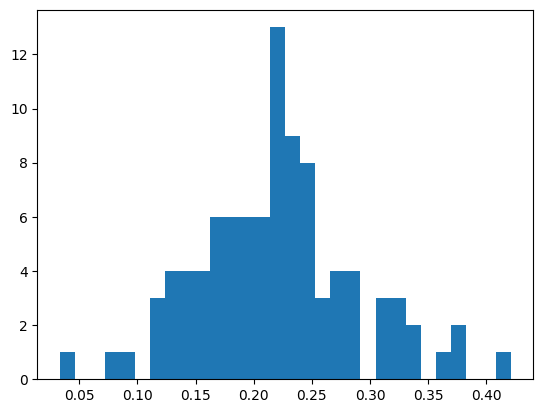

In [12]:
plt.hist(noun_ratios_gender['w'], bins=30)

(array([ 1.,  0.,  0.,  1.,  1.,  3.,  0.,  1.,  1.,  1.,  8.,  6.,  4.,
        11., 14.,  7.,  9.,  7.,  9.,  7.,  5.,  5.,  6.,  7.,  6.,  8.,
         2.,  1.,  2.,  2.]),
 array([0.01369863, 0.0261208 , 0.03854296, 0.05096513, 0.0633873 ,
        0.07580946, 0.08823163, 0.1006538 , 0.11307597, 0.12549813,
        0.1379203 , 0.15034247, 0.16276463, 0.1751868 , 0.18760897,
        0.20003113, 0.2124533 , 0.22487547, 0.23729763, 0.2497198 ,
        0.26214197, 0.27456413, 0.2869863 , 0.29940847, 0.31183064,
        0.3242528 , 0.33667497, 0.34909714, 0.3615193 , 0.37394147,
        0.38636364]),
 <BarContainer object of 30 artists>)

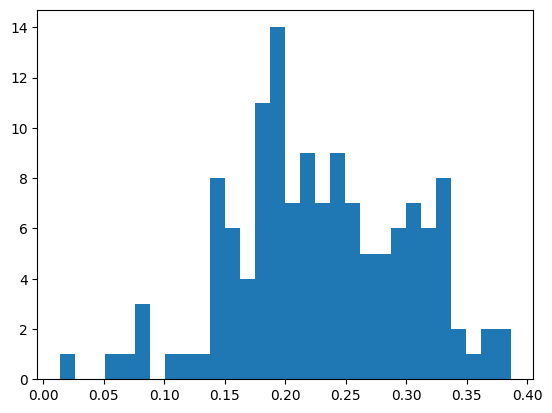

In [13]:
plt.hist(noun_ratios_gender['m'], bins=30)